In [2]:
# !conda list
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.cuda.set_device(0))

1
0
GeForce GTX 1070
None


In [3]:
from fastai.vision import *
from fastai.utils.mem import *

## I. Preparation

In [4]:
path = untar_data(URLs.CAMVID)
path_img = path/'images/'
path_lbl = path / 'labels'
get_y_fn = lambda x: path_lbl / f'{x.stem}_P{x.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['Void']

In [5]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

## II. Train small data

### 1: Make data

In [6]:
free = gpu_mem_get_free_no_cache()

size = (360, 480)
bs = 4

src = (SegmentationItemList.from_folder(path=path_img)
       .split_by_fname_file(fname='../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

### 2: Make model

In [6]:
metrics = acc_camvid
wd = 1e-2
learn = unet_learner(data=data, arch=models.resnet34, pretrained=True, metrics=metrics, wd=wd)
learn.summary()

### 3: Slight training

#### 3.a: find fair learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


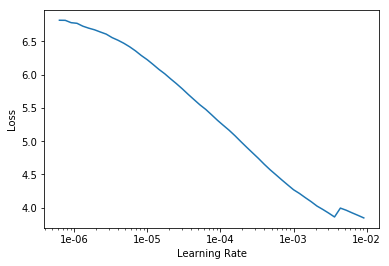

In [8]:
lr_find(learn=learn)
learn.recorder.plot()

#### 3.b: train big learning rate then save weights

In [10]:
lr = 3e-3
learn.fit_one_cycle(cyc_len=10, max_lr=slice(lr), pct_start=0.9)
learn.save('small-1')

epoch,train_loss,valid_loss,acc_camvid,time
0,1.106525,0.833904,0.802045,01:17
1,0.751805,0.561850,0.848546,01:16
2,0.661869,0.516736,0.858283,01:17
3,0.635127,0.504664,0.862289,01:15
4,0.604091,0.556295,0.866241,01:15
5,0.587394,0.458145,0.875571,01:15
6,0.580083,0.471826,0.872749,01:15
7,0.552526,0.434416,0.891172,01:15
8,0.521104,0.387548,0.887519,01:15
9,0.419977,0.320498,0.908215,01:16


### 4: Finetune training

#### 4.a: unfreeze learner

In [11]:
learn.load('small-1')
learn.unfreeze()

#### 4.b: train small learning rate then save weights

In [12]:
lrs = slice(lr/400, lr/4)
learn.fit_one_cycle(cyc_len=12, max_lr=lrs, pct_start=0.8)
learn.save('small-2')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.378272,0.315967,0.906833,01:20
1,0.369338,0.312707,0.908618,01:19
2,0.360863,0.294919,0.916595,01:19
3,0.351593,0.307803,0.911426,01:19
4,0.343284,0.306832,0.911619,01:19
5,0.330829,0.288926,0.922405,01:19
6,0.339193,0.303977,0.912797,01:19
7,0.327517,0.330508,0.906334,01:19
8,0.317279,0.302390,0.916986,01:19
9,0.316462,0.324853,0.906845,01:19


## III. Train big data

### 1: Make data

In [19]:
free = gpu_mem_get_free_no_cache()

size = (720, 960)
bs = 1

In [20]:
src = (SegmentationItemList.from_folder(path=path_img)
       .split_by_fname_file(fname='../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### 2: Make model

In [21]:
metrics = acc_camvid
wd = 1e-2
learn = unet_learner(data=data, arch=models.resnet34, pretrained=True, metrics=metrics, wd=wd)
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 360, 480]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 360, 480]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 360, 480]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 180, 240]    0          False     
______________________________________________________________________
Conv2d               [1, 64, 180, 240]    36,864     False     
______________________________________________________________________
BatchNorm2d          [1, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 180, 240]    0          False     
______________________________________________________________

### 3: Slight training

#### 3.a: find fair learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


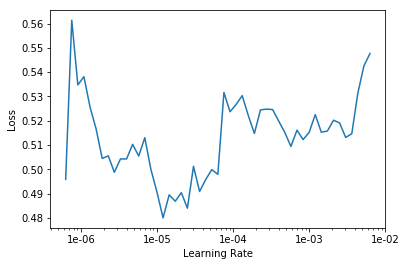

In [10]:
learn.load(name='small-2')
lr_find(learn=learn)
learn.recorder.plot()

#### 3.b: train big learning rate then save weights

In [11]:
lr = 3e-3
learn.fit_one_cycle(cyc_len=10, max_lr=slice(lr), pct_start=0.8)
learn.save(name='big-1')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.402818,0.352849,0.900761,05:05
1,0.393121,0.348187,0.903901,05:07
2,0.401300,0.379696,0.893195,05:02
3,0.439011,0.394345,0.898009,05:02
4,0.481675,0.383615,0.906092,05:02
5,0.453153,0.369043,0.899323,05:02
6,0.441371,0.358064,0.900863,05:02
7,0.475425,0.620480,0.845337,05:02
8,0.419445,0.287005,0.928186,05:02
9,0.291617,0.276682,0.923945,05:04


### 4: Finetune training

#### 4.a: unfreeze learner

In [12]:
learn.load(name='big-1')
learn.unfreeze()

#### 4.b: train small learning rate then save weights

In [13]:
lrs = slice(1e-6,lr/10)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.262489,0.279466,0.923337,05:31
1,0.243491,0.281675,0.920765,05:20
2,0.270370,0.270094,0.923716,05:21
3,0.238481,0.263069,0.926819,05:20
4,0.226761,0.263756,0.926615,05:17
5,0.218301,0.288080,0.923690,05:18
6,0.228594,0.272013,0.925061,05:22
7,0.242033,0.263236,0.928327,05:21
8,0.210219,0.264946,0.927838,05:19
9,0.208364,0.271845,0.926427,05:19


## ------------------------------------------------------------------

## IV. Explore data

### 1: Directly load.

In [14]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/minhnc-lab/.fastai/data/camvid/images/Seq05VD_f03240.png'),
 PosixPath('/home/minhnc-lab/.fastai/data/camvid/images/0001TP_009000.png'),
 PosixPath('/home/minhnc-lab/.fastai/data/camvid/images/0001TP_010140.png')]

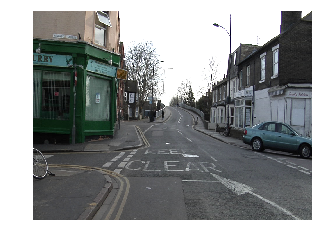

In [15]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

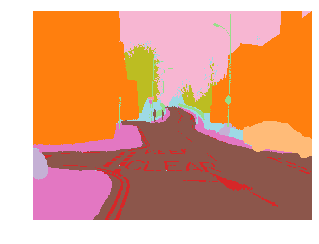

In [16]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [17]:
src_size = np.array(mask.shape[1:])
print(src_size)
print(mask.data)

[720 960]
tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])


### 2: Load through data model.

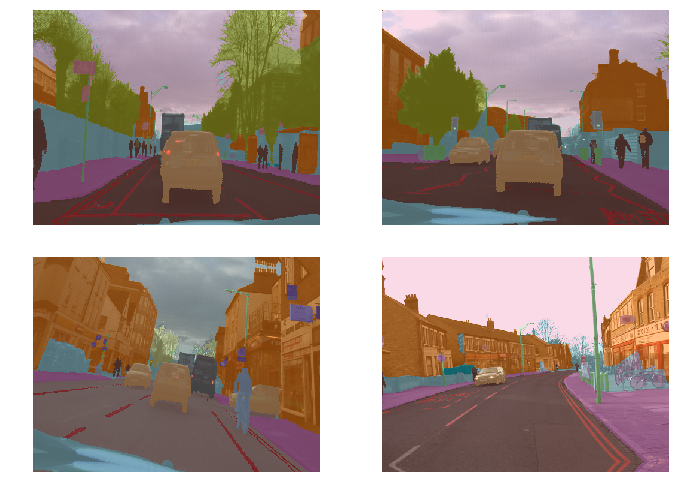

In [12]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(10,7))

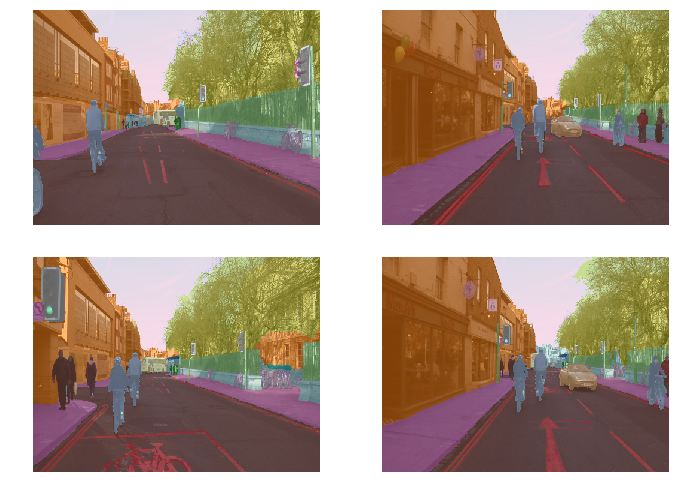

In [8]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(10,7))

## V. Test learner

In [22]:
learn.load(name='big-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/minhnc-lab/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/minhnc-lab/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

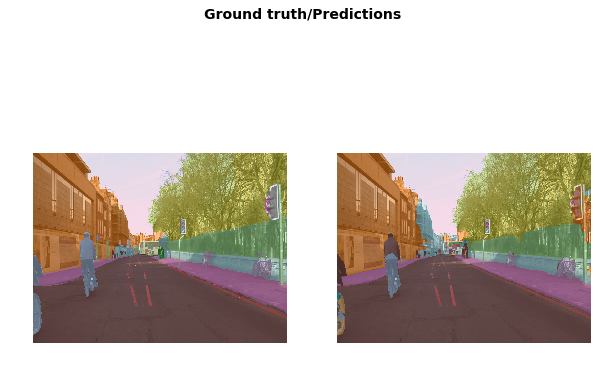

In [28]:
learn.show_results(ds_type=DatasetType.Valid, rows=2, figsize=(10,7))